In [1]:
import os,sys
import csv
import copy
import math
import collections
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from clawpack import pyclaw
from clawpack import riemann
from IPython.display import HTML
import numpy as np
from scipy.integrate import simps, trapz
from scipy.interpolate import interp1d
from scipy import signal
sys.path.append("/pymorph")

import logging
logger = logging.getLogger('pyclaw')
logger.setLevel(logging.CRITICAL)

import morph_geom_lib as mgl
import models.shallow_depth_morph_models as sdmodels
import schemes.avalanche_scheme 
from scipy.signal import find_peaks

from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import display, Math, Latex
from matplotlib import animation, rc

import schemes.weno as weno
import sediment_transport.sed_trans as sedtrans
from schemes.avalanche_scheme import avalanche_model, get_slope
from models.shallow_water_solver import shallow_water_solver

rc('animation', html='html5')
%matplotlib widget
%load_ext autoreload
%autoreload 2
%matplotlib inline
#plt.style.use(['dark_background'])

dx: 0.8682235195996664 cm
nx 1200


Text(0, 0.5, 'z (m)')

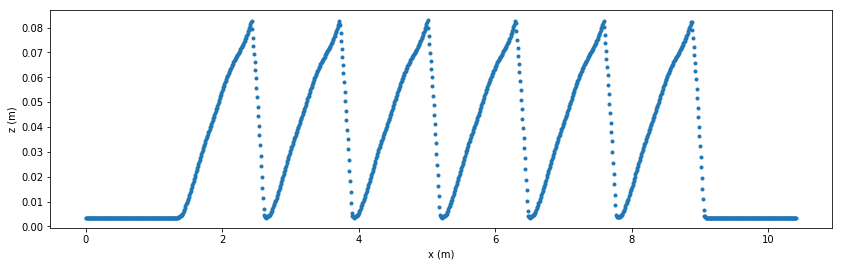

In [2]:
filepath = 'dune_profile_dune5_rep_runway.txt'

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
    


def readFile(filepath, resolution_cells = 800):
    xs = []
    zs = []
    with open(filepath) as f:
        for line in f:
            values = line.split(',')
            if is_number(values[0]) and is_number(values[1]):
                x = float(values[0])
                z = float(values[1])
                xs.append(x)
                zs.append(z)
                
    xs = np.array(xs)
    zs = np.array(zs)
    
    #--------------------------------
    # Increase the resolution on the grid
    #--------------------------------
    xmax = xs.max()
    nx = len(xs)
    f = interp1d(xs, zs)
    
    xnew = np.linspace(0., xmax, num=resolution_cells)
    znew = f(xnew)
    return xnew, znew

x0,z0 = readFile(filepath, resolution_cells = 1200)

dx = x0[1] - x0[0]

print('dx: {0} cm'.format(dx*100.))
print('nx {0}'.format(len(x0)))

fig = plt.figure(figsize=(14, 4))
plt.plot(x0,z0, '.')
plt.xlabel('x (m)')
plt.ylabel('z (m)')

In [3]:
#--------------------------------
# Set up the bed properties
#--------------------------------
D50 = 0.001
repose_angle = 30.
rho_particle = 2650.
nP = 0.4

#--------------------------------
# Set up the Boundary conditions
#--------------------------------
# 32 cm Case 
Qc132 = 0.0455
Qc120 = 0.020
B = 0.76
Qtotal32 = Qc132 * 3.
Qtotal20 = Qc120 * 3.
q32cm = Qtotal32 / B
q20cm = Qtotal20 / B

sOut32 = 0.357
sOut20 = 0.237

#--------------------------------
# Set up the Flow Proerties
#--------------------------------
mannings_n = 0.024
bed_slope = 1.26/1000.
ks=0.0033

In [21]:
#--------------------------------
#  Setup the model run parameters
#--------------------------------
simTime = 60*10       # Runtime in seconds
dt = 10                # Time step size (s)
nt = int(simTime/dt)  # Number of time steps
extractionTime = 60.*1

 Starting simulation....
Number of time steps: 1.0 mins
Grid dx = 0.008682235195996663
Grid nx = 1200
Initializing hydrodynamic model...
Completed the intialization of the model
D50:    0.001
Rho Particle:    2650.0
Angle Repose Degrees:    30.0
Time step: 1.0 mins - uavg: 0.552715255814801 - Elevation 0.34849547031812733
Courant number: 386.4540597226015
Time step: 2.0 mins - uavg: 0.5670412346062031 - Elevation 0.34841876956590867
Courant number: 72.83238120375071
Time step: 3.0 mins - uavg: 0.5695838008551953 - Elevation 0.3482958390086525
Courant number: 381.73322042245786
Time step: 4.0 mins - uavg: 0.5676759846747729 - Elevation 0.34829092391817296
Courant number: 44.577255346140475
Time step: 5.0 mins - uavg: 0.5666579771161603 - Elevation 0.34818892581663485
Courant number: 302.0074676429623
Time step: 6.0 mins - uavg: 0.5661591624516018 - Elevation 0.34815540959341923
Courant number: 24.458630723600034
Time step: 7.0 mins - uavg: 0.5663951316224743 - Elevation 0.34810412681163

Text(0, 0.5, 'z (m)')

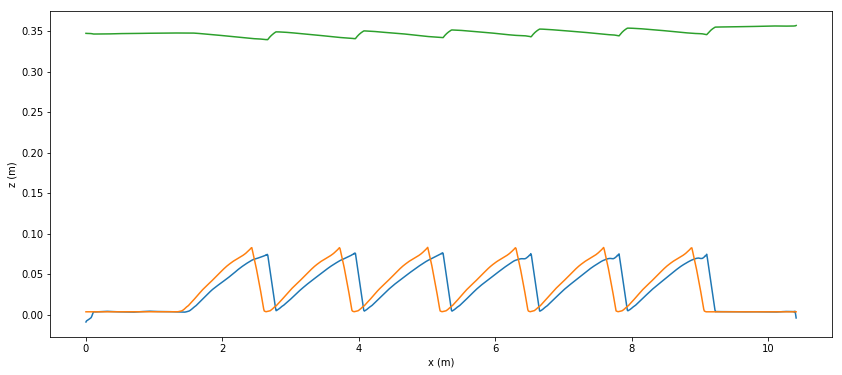

In [22]:
run_name = 'dune_5_q_{0}_h_{1}_D50_{2}'.format('32m','357mm','1mmgrass')

model = sdmodels.ModifiedShallowHydroMorphologicalModel()

#--------------------------------
# Set up the geometry
#--------------------------------
xc = x0.copy()
zc = z0.copy()
nx = len(xc)

model.setup_domain(x0, z0, dx)
model.setup_bed_properties( D50, repose_angle=repose_angle, rho_particle = rho_particle, nP = nP)
model.flow_boundary_conditions(q32cm, sOut32)
model.setup_chezy_hydro_model(ks, bed_slope)

#--------------------------------
# Set up the Morphodynamic Proerties
#--------------------------------
#morph_model = sdmodels.EulerWenoModel()
morph_model = sdmodels.TVD2ndWenoModel()
model.setup_morpho_model( morph_model, 
                           useAvalanche = True, 
                           useSmoother = False, 
                           sed_model='bagnold', 
                           useSlopeAdjust = False)
model.set_scale_factor(0.25)

zc, u, q, h, qbedload = model.run(simTime, dt, extractionTime, None)
surf = zc + h

df = model.get_wave_dataframe()
df.to_csv('_output/{0}_waves.csv'.format(run_name))
np.save('_output/{0}_z.npy'.format(run_name),zc)
verts = model._verts
np.save('_output/{0}_verts.npy'.format(run_name, verts),verts)


fig = plt.figure(figsize=(14, 6))
plt.plot(xc,zc)
plt.plot(x0,z0)
plt.plot(xc, surf)

plt.xlabel('x (m)')
plt.ylabel('z (m)')

In [23]:
#run_name = 'dune_5_q_{0}_h_{1}_D50_{2}'.format('32m','357mm','1.2mm')

verts32_10mm = np.load(os.path.join('_output','{0}_verts.npy'.format(run_name)))

In [24]:
def calculate_wave_height( z):
    top_peaks, _ = find_peaks(z, height = z.mean()*1.1)
    bottom_peaks, _ = find_peaks(-1.*z, height = z.mean()*-0.8, distance = int(1.2/dx))

    ztop = [z[i] for i in top_peaks]
    zbottom = [z[i] for i in bottom_peaks]

    ztop = np.array(ztop)
    ztop = np.delete(ztop, ztop.argmin())
    
    zbottom = np.array(zbottom)
    zbottom = np.delete(zbottom, zbottom.argmax())
    

    return ztop.mean() - zbottom.mean()
                
            
    
def calculate_wave_length(z,dx):
    peaks, _ = find_peaks(-1.*z, height = z.mean()*-1., distance = int(1.2/dx))
    lengths = []
    last_peak = None
    for peak in peaks:
        if last_peak == None:
            last_peak = peak
        else:
            
            tmpLength = dx * (peak-last_peak)
            
            if tmpLength > 1.2:
                lengths.append(tmpLength)
                last_peak = peak
                
    lengths = np.array(lengths)
    #lengths = np.delete(lengths, lengths.argmin())
    return lengths
    
def calculate_wave_movement(last_peak_index, current_z):
    
    peaks, _ = find_peaks(-1.*current_z, height = current_z.mean()*-0.8, distance = int(1.2/dx))
    
    updated_peak = None
    for peak in peaks:
        if peak > last_peak_index:
            updated_peak = peak
            #print(peak, last_peak_index)
            break

    return updated_peak

def calculate_wave_speed(verts, dx, dt):
    last_peak_index = None
    velocities = []
    timesteps = []
    base_index = 2
    step_index = 4
    for t in range(0, (verts.shape[0]), step_index):
        current_z = verts[t,:,1]
        peaks, _  = find_peaks(-1.*current_z, height = -1*current_z.mean(), distance=100)
        if last_peak_index is not None:
            delta = calculate_wave_movement(last_peak_index, current_z)
            last_peak_index = peaks[base_index]
            velocities.append(delta*dx/(dt*step_index))
            timesteps.append( dt * t )
        last_peak_index = peaks[base_index]
    return velocities, timesteps

def plot_results(verts):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,15))

    heights = [calculate_wave_height(verts[t,:,1]) for t in range((verts.shape[0]))]
    times = [t*5. for t in range((verts.shape[0]))]

    ax1.plot(times, heights)
    ax1.set_xlabel('Time (mins)')
    ax1.set_ylabel('$\Delta$ (m)')
    x = verts[0,:,0]
    dx = x[1] - x [0]
    lengths = [calculate_wave_length(verts[t,:,1],dx).mean() for t in range((verts.shape[0]))]
    ax2.plot(times, lengths)
    ax2.set_xlabel('Time (mins)')
    ax2.set_ylabel('$\Lambda$ (m)')
    ax2.set_ylim([0, 3.0])

    for t in range(0, (verts.shape[0]),15):
        z = verts[t,:,1]
        h = verts[t,:,4]
        x = verts[t,:,0]
        timestep = t * 5.
        ax3.plot(x,z, label='{0} mins'.format(timestep))
        ax3.plot(x,z+h, 'b')

    ax3.legend()
    ax3.set_xlabel('x (m)')
    ax3.set_ylabel('z (m)')


    v, timesteps = calculate_wave_speed(verts, dx, 5)
    ax4.plot(timesteps,v)
    ax4.set_ylim([0, 0.5])

    ax4.set_xlabel('Time (mins)')
    ax4.set_ylabel('Dune migration rate (m/min)')

    f.subplots_adjust(hspace=0.3)
    
def make_animation(verts):
    # First set up the figure, the axis, and the plot element we want to animate
    fig = plt.figure(figsize=(12, 3))
    ax = plt.axes(xlim=(0, 8), ylim=(0, 0.1))

    x0 = verts[0,:,0]
    z0 = verts[0,:,1]

    plt.plot(x0,z0)
    line, = ax.plot([], [], lw=2)



    # initialization function: plot the background of each frame
    def init():
        line.set_data([], [])
        return line,

    # animation function.  This is called sequentially
    def animate(i):
        x = verts[i,:,0]
        y = verts[i,:,1]
        line.set_data(x, y)
        return line,
    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=9, interval=80, blit=True)
    return anim

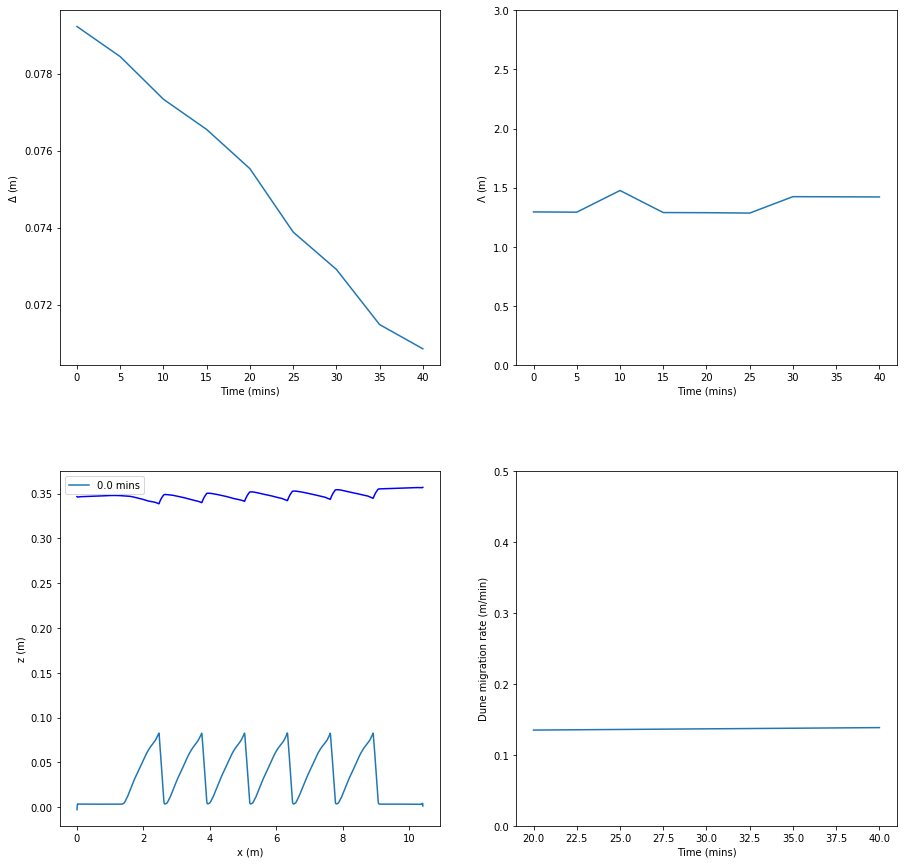

In [25]:
plot_results(verts32_10mm)

2019-05-24 04:44:47,599 INFO CLAW: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2019-05-24 04:44:47,601 INFO CLAW: MovieWriter.run: running command: ['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '864x216', '-pix_fmt', 'rgba', '-r', '12.5', '-loglevel', 'quiet', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/tmp/tmp16yvqmoh/temp.m4v']


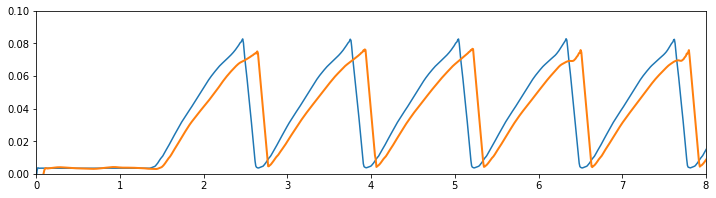

In [26]:
make_animation(verts32_10mm)

In [ ]:
run_name = 'dune_5_q_{0}_h_{1}_D50_{2}'.format('32m','357mm','1mmgrass_f05')

model = sdmodels.ModifiedShallowHydroMorphologicalModel()

#--------------------------------
# Set up the geometry
#--------------------------------
xc = x0.copy()
zc = z0.copy()
nx = len(xc)

model.setup_domain(x0, z0, dx)
model.setup_bed_properties( D50, repose_angle=repose_angle, rho_particle = rho_particle, nP = nP)
model.flow_boundary_conditions(q20cm, sOut20)
model.setup_chezy_hydro_model(ks, bed_slope)

#--------------------------------
# Set up the Morphodynamic Proerties
#--------------------------------
#morph_model = sdmodels.EulerWenoModel()
morph_model = sdmodels.TVD2ndWenoModel()
model.setup_morpho_model( morph_model, 
                           useAvalanche = True, 
                           useSmoother = False, 
                           sed_model='bagnold', 
                           useSlopeAdjust = False)
model.set_scale_factor(0.5)

zc, u, q, h, qbedload = model.run(simTime, dt, extractionTime, None)
surf = zc + h

df = model.get_wave_dataframe()
df.to_csv('_output/{0}_waves.csv'.format(run_name))
np.save('_output/{0}_z.npy'.format(run_name),zc)
verts = model._verts
np.save('_output/{0}_verts.npy'.format(run_name, verts),verts)


fig = plt.figure(figsize=(14, 6))
plt.plot(xc,zc)
plt.plot(x0,z0)
plt.plot(xc, surf)

plt.xlabel('x (m)')
plt.ylabel('z (m)')

In [ ]:
verts = model._verts

In [ ]:
np.save('_output/{0}_verts.npy'.format(run_name, verts),verts)

In [ ]:
verts2 = np.load('_output/{0}_verts.npy'.format(run_name, verts))

In [ ]:
plot_results(verts)

In [ ]:
make_animation(verts)

In [ ]:
verts.shape